### Goal : Take a few thousand surnames from 18 languages of origin, and predict which language a name is based on the spelling
<br>
Source : <a src="https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html" target="_blank">https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html</a> 

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [3]:
def findFiles(path) : return glob.glob(path)

In [4]:
print(findFiles('../data/NLP Pure RNN/names/*.txt'))

['../data/NLP Pure RNN/names\\Arabic.txt', '../data/NLP Pure RNN/names\\Chinese.txt', '../data/NLP Pure RNN/names\\Czech.txt', '../data/NLP Pure RNN/names\\Dutch.txt', '../data/NLP Pure RNN/names\\English.txt', '../data/NLP Pure RNN/names\\French.txt', '../data/NLP Pure RNN/names\\German.txt', '../data/NLP Pure RNN/names\\Greek.txt', '../data/NLP Pure RNN/names\\Irish.txt', '../data/NLP Pure RNN/names\\Italian.txt', '../data/NLP Pure RNN/names\\Japanese.txt', '../data/NLP Pure RNN/names\\Korean.txt', '../data/NLP Pure RNN/names\\Polish.txt', '../data/NLP Pure RNN/names\\Portuguese.txt', '../data/NLP Pure RNN/names\\Russian.txt', '../data/NLP Pure RNN/names\\Scottish.txt', '../data/NLP Pure RNN/names\\Spanish.txt', '../data/NLP Pure RNN/names\\Vietnamese.txt']


In [5]:
import unicodedata
import string

In [6]:
all_letters = string.ascii_letters + " .,;'"
# abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'

In [7]:
n_letters = len(all_letters)

In [8]:
n_letters

57

In [9]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [10]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [11]:
def readLines(filename):
    lines = open(filename, encoding='utf-8')\
                .read()\
                .strip()\
                .split('\n')
    return [unicodeToAscii(line) for line in lines]

**splitext**<br>&nbsp;&nbsp;&nbsp; ('Korean.txt') => ('Korean','.txt')<br>
**os.path.basename**<br>&nbsp;&nbsp;&nbsp;('C:/User/abc.txt') => ('abc.txt')<br>

In [12]:
category_lines = {}
all_categories = []

In [13]:
for filename in findFiles('../data/NLP Pure RNN/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [14]:
n_categories = len(all_categories)

In [15]:
n_categories

18

In [16]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turning Names into Tensor

All the names are organized. We need to turn them into Tensors to make any use of them. <br><br>
To represent a single letter, we use a "one-hot vector" of size `<1 x n_letters>`.<br><br>
To make a word we join a bunch of those into a 2D matrix `<line_length x 1 x n_letters>`.<br><br>
That extra 1 dimension is becuse PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [17]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

In [18]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [19]:
letterToTensor('g')

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [20]:
# Turn a line into a <line_length x 1 x n_letters>
# Array of one-hot letter vectors
def wordToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [21]:
print(wordToTensor('Jones').shape)

torch.Size([5, 1, 57])


In [22]:
for i, letter in enumerate('Jones'):
    print(i, letter)

0 J
1 o
2 n
3 e
4 s


## Creating the Network

This RNN Module is just like 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output
<br>
<img src="../img/RNN network.png"/>

In [23]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [24]:
n_hidden = 128

In [25]:
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network, we need to pass an input and a previous hidden state. <br>We'll get back the output and a next hidden state

In [26]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [27]:
next_hidden.shape

torch.Size([1, 128])

In [28]:
input = wordToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print("Output Shape : ", output.shape)
print("Next Hidden Shape :", next_hidden.shape)

Output Shape :  torch.Size([1, 18])
Next Hidden Shape : torch.Size([1, 128])


In [29]:
output.topk(3)

torch.return_types.topk(
values=tensor([[-2.8139, -2.8258, -2.8278]], grad_fn=<TopkBackward>),
indices=tensor([[14,  5, 17]]))

## Training
### Preaparing for Training

In [30]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [31]:
print(categoryFromOutput(output))

('Czech', 2)


In [32]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [33]:
def randomTrainingExample():
    category = randomChoice(all_categories)
    ran_word = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    word_tensor = wordToTensor(ran_word)
    return category, ran_word, category_tensor, word_tensor

In [36]:
for i in range(10):
    category, ran_word, category_tensor, word_tensor = randomTrainingExample()
    print('Category = ', category, '/ word', ran_word)

Category =  Arabic / word Shammas
Category =  Vietnamese / word Pham
Category =  Scottish / word Graham
Category =  Scottish / word Black
Category =  Russian / word Jadrihinsky
Category =  Spanish / word Viteri
Category =  Arabic / word Dagher
Category =  Dutch / word Peij
Category =  Dutch / word Lyon
Category =  Korean / word Yeo


### Training the Network

For the loss function `nn.NLLLoss` is appropriate, since the last layer of the RNN is `nn.LogSoftmax`.<br>
The negative log likelihood loss. It is useful to train a classification problem with C classes.

In [37]:
criterion = nn.NLLLoss()

In [42]:
learning_rate = 0.005 # If it is too high, it might explode. If too low, it might not learn

def train(category_tensor, word_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(word_tensor.shape[0]):
        output, hidden = rnn(word_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item()

In [40]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [44]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters+1):
    category, ran_word, category_tensor, word_tensor = randomTrainingExample()
    output, loss = train(category_tensor, word_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✔' if guess == category else '❌ (%s)' % category
        print(f'{iter} {(iter/n_iters * 100):.3f}%% ({timeSince(start)}) {loss:.4f} {ran_word} / {guess} {correct}')
        
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5.000%% (0m 21s) 2.4301 Reilly / Czech ❌ (Irish)
10000 10.000%% (0m 42s) 2.0369 Faltysek / Polish ❌ (Czech)
15000 15.000%% (1m 3s) 1.4069 Saller / German ✔
20000 20.000%% (1m 24s) 0.7602 Perreault / French ✔
25000 25.000%% (1m 45s) 3.1442 Horowitz / Spanish ❌ (German)
30000 30.000%% (2m 7s) 1.6282 Basurto / Portuguese ❌ (Spanish)
35000 35.000%% (2m 28s) 1.4905 Faure / French ✔
40000 40.000%% (2m 49s) 2.1445 Martin / Arabic ❌ (French)
45000 45.000%% (3m 10s) 2.6890 Koenig / Russian ❌ (German)
50000 50.000%% (3m 32s) 4.0532 Jelen / English ❌ (Polish)
55000 55.000%% (3m 53s) 2.7659 Baudin / Russian ❌ (French)
60000 60.000%% (4m 14s) 2.7837 Jonas / Greek ❌ (Czech)
65000 65.000%% (4m 35s) 3.2210 Vandale / French ❌ (Dutch)
70000 70.000%% (4m 57s) 5.3053 Oshin / Irish ❌ (Japanese)
75000 75.000%% (5m 18s) 0.2201 Shiraishi / Japanese ✔
80000 80.000%% (5m 39s) 0.5079 Kerner / German ✔
85000 85.000%% (6m 0s) 1.1158 Dasios / Portuguese ❌ (Greek)
90000 90.000%% (6m 22s) 1.3870 Santana / Spanis

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

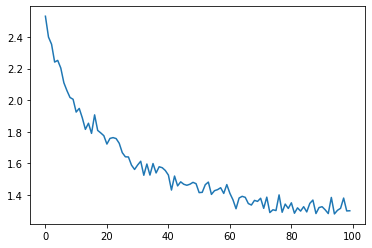

In [49]:
plt.figure()
plt.plot(all_losses)

### Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix.

In [50]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

In [54]:
def evaluate(word_tensor):
    hidden = rnn.initHidden()
    
    for i in range(word_tensor.shape[0]):
        output, hidden = rnn(word_tensor[i], hidden)
    
    return output

In [55]:
for i in range(n_confusion):
    category, word, category_tensor, word_tensor = randomTrainingExample()
    output = evaluate(word_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

In [56]:
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

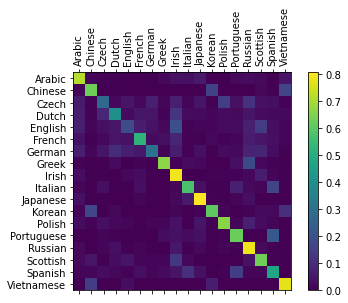

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

### Running on User Input

In [58]:
def predict(input_word, n_predictions=3):
    print(f'\n> {input_word}')
    with torch.no_grad():
        output = evaluate(wordToTensor(input_word))
        
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print(f'({value}) {all_categories[category_index]}')
            predictions.append([value, all_categories[category_index]])

In [59]:
predict('Dovesky')


> Dovesky
(-0.4458087682723999) Russian
(-1.2871330976486206) Czech
(-3.3742804527282715) Polish


In [60]:
predict('Yoo')


> Yoo
(-0.2691521942615509) Korean
(-1.5232319831848145) Chinese
(-5.505514621734619) Spanish


In [61]:
predict('yakobchuk')


> yakobchuk
(-0.015270699746906757) Russian
(-4.713506698608398) Czech
(-5.627980709075928) Polish


In [72]:
predict('Patel')


> Patel
(-1.171980857849121) Czech
(-1.8566100597381592) Spanish
(-2.292421817779541) Dutch


In [30]:
predict('Hammed')

NameError: name 'predict' is not defined